# How similar are two maps?

### Using the earth movers distance to quantify the similarity between two maps with implementations in Python and R.

Let's assume you have a map that shows the distribution of people within Berlin - e.g., through mobile phone data, GPS tracking, stationary sensors or simply a survey. 
You aggregate the data spatially (in this example we use the "Planungsräume Berlin") and get the following result:

(Source of tessellation "Planungsräume Berlin": [Statistisches Landesamt Berlin via the Geoportal Berlin](https://fbinter.stadt-berlin.de/fb/index.jsp?loginkey=zoomStart&mapId=lor_plan@senstadt&bbox=381979,5817677,396282,5825516))

In [20]:
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

In [21]:
def choropleth(gdf, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    gdf.plot(column="example_data", cmap="viridis_r", 
        linewidth=0.5, ax=ax, edgecolor="#FFFFFF", missing_kwds= dict(color = "lightgrey",) )

    ax.axis("off")
    ax.set_title(title)
    sm = plt.cm.ScalarMappable(cmap="viridis_r", 
        norm=plt.Normalize(vmin=gdf.example_data.min(), vmax=gdf.example_data.max()))
    sm._A = []# add the colorbar to the figure
    # set the range for the choropleth
    fig.colorbar(sm, ax = ax)

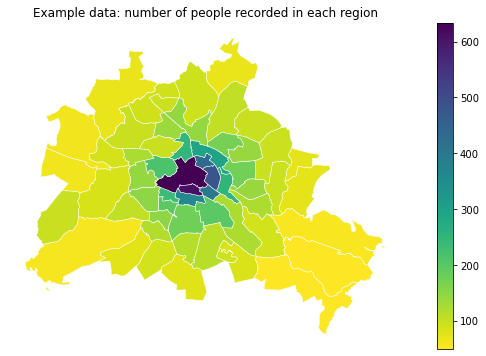

In [22]:
example = gpd.read_file("data/example.gpkg")
choropleth(example, title = "Example data: number of people recorded in each region")

A few weeks later you collect the data again and get a second distribution.
(Or to speak in terms of privacy use cases: you add noise to the data and get a second distribution). 

Now imagine two scenarios. In scenario 1) you get the following new output:

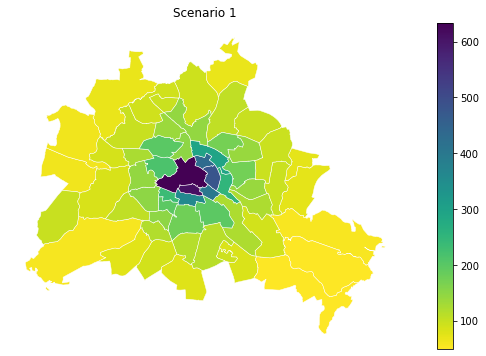

In [23]:
scenario1 = gpd.read_file("data/example_similar.gpkg")
choropleth(scenario1, title = "Scenario 1")

You can see a change of 100 people who are recorded less within one tile and more in the neighboring tile.

<img src="img/scenario1.png" alt="Scenario 1" style="width:400px;"/>

In scenario 2) you see the following:

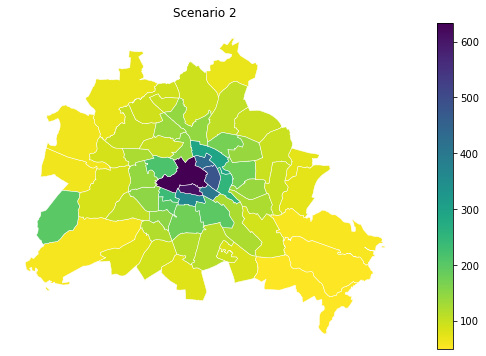

In [24]:
scenario2 = gpd.read_file("data/example_different.gpkg")
choropleth(scenario2, title = "Scenario 2")

In scenario 2 there are 100 people less in the same tile as in scenario two but 100 people more in a tile at the outskirts of the city.

<img src="img/scenario2.png" alt="Scenario 2" style="width:400px;"/>

Intuitively, the first scenario looks more similar to the original data than the second. In both scenarios, 100 people moved from the same origin tile to another tile. Though in scenario 1 the new tile is a neighboring cell of the origin while in scenario 2 the cell is at the outskirts of the city.
One could imagine explanations for the changes in scenario 1 as for example usual variability in people's behavior, or maybe a coffee shop down the street had a special offer. Or it could even be due to inaccuracies in the data collection instrument - maybe there are many people right at the border of the two regions and the tracked GPS signal is not accurately assigned to the correct region. The movement to a region far away in scenario 2 seems to be a more significant change. Intuitively the pattern of the map has changed. One reason, this change seems bigger, is because it is more effort to move multiple kilometers from the original location away than it is to move a few hundred meters.

But how can you measure this (dis-)similarity?

In [25]:
df = example[["PGR_NAME", "PGR_ID", "example_data"]].merge(
    scenario1[["PGR_ID", "example_data"]], on = "PGR_ID", suffixes=("", "_scenario1"))\
        .merge(scenario2[["PGR_ID", "example_data"]], on = "PGR_ID", suffixes=("_original", "_scenario2"))


## Measuring similarity

Common measures that compare the similarity between distributions do not account for spatial distance. E.g., the [mean absolute percentage error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error) (by how many percent does each original tile diverge from its scenario equivalent?), the [Jensen-Shannon metric](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html) (how similar are two probability distributions?) or the [correlation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html) will be similar for both scenarios. This is because the spatial component is not being considered and all tiles are treated equally.

In [26]:
from scipy import stats
from sklearn import metrics
from scipy.spatial import distance

mre_scenario_1 = metrics.mean_absolute_percentage_error(df.example_data_original, df.example_data_scenario1)
mre_scenario_2 = metrics.mean_absolute_percentage_error(df.example_data_original, df.example_data_scenario2)

js_distance_1 = distance.jensenshannon(df.example_data_original, df.example_data_scenario1)
js_distance_2 = distance.jensenshannon(df.example_data_original, df.example_data_scenario2)

biserial_correlation_1,_ = stats.pointbiserialr(df.example_data_original, df.example_data_scenario1)
biserial_correlation_2,_ = stats.pointbiserialr(df.example_data_original, df.example_data_scenario2)

In [27]:
print("Mean mean absolute percentage error scenario 1: " + str(round(mre_scenario_1 * 100, 2)) + "%")
print("Mean mean absolute percentage error scenario 2: " + str(round(mre_scenario_2 * 100, 2)) + "%")
print("Jensen-Shannon distance scenario 1: " + str(round(js_distance_1, 4)))
print("Jensen-Shannon distance scenario 2: " + str(round(js_distance_2, 4)))

print("Biserial correlation coefficient scenario 1: " + str(round(biserial_correlation_1, 4)))
print("Biserial correlation coefficient scenario 2: " + str(round(biserial_correlation_2, 4)))

Mean mean absolute percentage error scenario 1: 2.41%
Mean mean absolute percentage error scenario 2: 2.41%
Jensen-Shannon distance scenario 1: 0.0401
Jensen-Shannon distance scenario 2: 0.0401
Biserial correlation coefficient scenario 1: 0.9893
Biserial correlation coefficient scenario 2: 0.9893


### Eart movers distance (Wassertein metric)

To capture the spatial distance, we need to use a measure that can account for that. The Wasserstein metric, also called earth movers distance (EMD), can do exactly this.

"Intuitively, given two distributions, one can be seen as a mass of earth properly spread in space, the other as a collection of holes in that same space. Then, the EMD measures the least amount of work needed to fill the holes with earth. Here, a unit of work corresponds to transporting a unit of earth by a unit of ground distance." [Here is a detailed explanation of the EMD.](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/RUBNER/emd.htm). Clear and illustrative explanations of the earth movers distance are also given [here](https://towardsdatascience.com/earth-movers-distance-68fff0363ef2) and [here](https://towardsdatascience.com/using-statistical-distance-metrics-for-machine-learning-observability-4c874cded78).

### Python implementation

Now we have the theory, but how do we implement this in python?

The [implementation by Scipy of the wasserstein distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) only works with 1D distributions. But we have a 2D distribution - latitude and longitude.

The EMD is also used as a metric to compare the similarity between images (see, e.g., [this](https://link.springer.com/article/10.1023/A:1026543900054)). This is why there is an [implementation by the OpenCV (Open Source Computer Vision Library)](https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html#emd) for 2D distributions, which we can use for our purposes.

Unfortunately, the documentation is not very intuitive to understand but thankfully there is a [blog article by Sam van Kooten](https://samvankooten.net/2018/09/25/earth-movers-distance-in-python/) who explains this nicely. His illustration also shows visually, how the earth movers distance works for images:

<img src="img/cv2_emd_example.png" alt="Sam von Kooten example" style="width:400px;"/>

So how does the CV2 implementation work in detail? Let's have a look at the [documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html#emd):

<img src="img/docu_emd_cv2.png" alt="CV2 EMD documentation" style="width:800px;"/>

According to the documentation, we need a `signature` as input format. Let's assume we have a nine pixel image and each pixel holds one value:

```
[2,3,5
 1,2,4
 2,1,2]
```

Then we can assign each pixel in the matrix a coordinate:

```
[(0,0), (0,1), (0,2)
 (1,0), (1,1), (1,2)
 (2,0), (2,1), (2,2)]
```

With this information, we can construct a signature of `size = 9` and with `dims=2`:

```
[2, 0,0,
 3, 0,1,
 5, 0,2,
 1, 1,0,
 2, 1,1,
 4, 1,2,
 2, 2,0,
 1, 2,1,
 2, 2,2]
 ```

For our use case, we cannot use the implementation of Sam van Kooten to translate our data into a signature, because we do not have a raster where each cell has a similar distance to its neighbors. Therefore, we cannot construct the coordinates as easily as just described in the example. 

First of all, we need to define a single point for each tile in our tessellation. For simplicity, we take the centroid. 

Then need to consider the following: We cannot simply use the geographical coordinates and compute the euclidean distance (this would only be possible if the earth was flat).

Therefore, we have two options:

1. We project our centroids to a projected coordinate reference system (CRS) and take those coordinates as input for to construct our signature. ([Here you can learn more about the difference between a geographical and a projected CRS](https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/coordinate-systems-difference/)).
2. We make use of the option in the `cv2.EMD` function to use a custom `cost_matrix` instead of passing coordinates in the signature. We can use the geographical coordinates to compute the haversine distance between all centroids and costruct a cost matrix.

In [28]:
import cv2

#### Option 1: use projected coordinates


In [29]:
# use the world mercator EPSG:3395 projection
def signature_opt1(gdf, crs):
    centroids = gdf.geometry.to_crs(crs).centroid

    sig = np.empty((len(gdf), 3), dtype=np.float32) # float32 needed as input for cv2.emd!
    # we need to normalize the data in case the total n of the two compared distributions are not equal
    sig[:,0] = gdf.example_data / gdf.example_data.sum()
    sig[:,1] = centroids.x
    sig[:,2] = centroids.y
    return sig

In [30]:
# using the EPSG:3035 projection ETRS89-extended / LAEA Europe
sig_original = signature_opt1(example, 3035)
sig_scen1 = signature_opt1(scenario1, 3035)
sig_scen2 = signature_opt1(scenario2, 3035)

emd_scen1, _ , _ = cv2.EMD(sig_original, sig_scen1, distType = cv2.DIST_L2)
emd_scen2, _ , _ = cv2.EMD(sig_original, sig_scen2, distType = cv2.DIST_L2)

print("Earth movers distance scenario 1 (CRS: EGSG:3035): " + str(round(emd_scen1)) + " meters")
print("Earth movers distance scenario 2 (CRS: EGSG:3035): " + str(round(emd_scen2)) + " meters")


Earth movers distance scenario 1 (CRS: EGSG:3035): 30 meters
Earth movers distance scenario 2 (CRS: EGSG:3035): 196 meters


One drawback of this method is, that you need to use a proper projected CRS for your data, otherwise your results might not be accurate. I used the EGSG:3035 which is suitable for Europe. If I would have used, for example, the world mercator EPSG:3395 projection, the results would have been slightly different, as this projection is not perfectly accurate for Berlin:

In [31]:
# use the world mercator EPSG:3395 projection

sig_original = signature_opt1(example, 3395)
sig_scen1 = signature_opt1(scenario1, 3395)
sig_scen2 = signature_opt1(scenario2, 3395)

emd_scen1, _ , _ = cv2.EMD(sig_original, sig_scen1, distType = cv2.DIST_L2)
emd_scen2, _ , _ = cv2.EMD(sig_original, sig_scen2, distType = cv2.DIST_L2)

print("Earth movers distance scenario 1 (CRS: EGSG:3395): " + str(round(emd_scen1)) + " meters")
print("Earth movers distance scenario 2 (CRS: EGSG:3395): " + str(round(emd_scen2)) + " meters")


Earth movers distance scenario 1 (CRS: EGSG:3395): 50 meters
Earth movers distance scenario 2 (CRS: EGSG:3395): 322 meters


If you are not familiar with the correct usage of different CRS, option two might be better suited:

#### Option 2: construct a custom cost_matrix with the haversine distance

We compute a custom cost matrix for all coordinate pairs using the haversine distance.

For the cost matrix, we need to define the distance between all points. All points within the first distribution (signature 1) to all points in the second distribution (signature 2). In our case, the points in both distributions are the same, therefore, each distance is included twice (A-B and B-A). In our case, this is the same distance but one could also use asymmetic distances (e.g., you have an uphill location and include the effort needed to go uphill while it saves work to go downhill).

The cost matrix has a dimension of `n x m` where n is the number of points in the first distribution (signature 1) and m the number of points in the second distribution (signature 2). In our case `n=m`, but for the earth movers distance, the points in the first distribution do not have to be the same amount or the same points at all as within the second distribution.

We construct the `cost_matrix` as follows:

In [32]:
from haversine import haversine, Unit

def get_cost_matrix(gdf1, gdf2):
    gdf1_centroids = gdf1.to_crs(3395).centroid.to_crs(4326)
    gdf2_centroids = gdf2.to_crs(3395).centroid.to_crs(4326)
    coords_sig1 = list(zip(gdf1_centroids.y, gdf1_centroids.x))
    coords_sig2 = list(zip(gdf2_centroids.y, gdf2_centroids.x))

    #get all potential combinations between all points from sig1 and sig2
    grid = np.meshgrid(range(0, len(coords_sig1)), 
                        range(0, len(coords_sig2)))
    tile_combinations = np.array([grid[0].flatten(), grid[1].flatten()])
    
    # create an empty cost matrix with the length of all possible combinations
    cost_matrix = np.empty(tile_combinations.shape[1], dtype = np.float32) # float32 needed as input for cv2.emd!

    # compute haversine distance for all possible combinations
    for column in range(0, tile_combinations.shape[1]):
        tile_1 = tile_combinations[0, column]
        tile_2 = tile_combinations[1, column]
        cost_matrix[column]  = haversine(coords_sig1[tile_1], coords_sig2[tile_2], unit = Unit.METERS)
    
    # reshape array to matrix
    return np.reshape(cost_matrix, (len(coords_sig1),len(coords_sig2)))

# as the coordinates are the same in both scenarios 
# you could use the same cost matrix for both scenarios
cost_matrix1 = get_cost_matrix(example, scenario1)
cost_matrix2 = get_cost_matrix(example, scenario2)

In [33]:
sig_original = np.array(example.example_data, dtype = np.float32)
sig_scen1 = np.array(scenario1.example_data, dtype = np.float32)
sig_scen2 = np.array(scenario2.example_data, dtype = np.float32)

In [34]:
emd_scen1, _ , _ = cv2.EMD(sig_original, sig_scen1, distType = cv2.DIST_USER, cost = cost_matrix1)
emd_scen2, _ , _ = cv2.EMD(sig_original, sig_scen2, distType = cv2.DIST_USER, cost = cost_matrix2)

print("Earth movers distance scenario 1: " + str(round(emd_scen1)) + " meters")
print("Earth movers distance scenario 2: " + str(round(emd_scen2)) + " meters")


Earth movers distance scenario 1: 30 meters
Earth movers distance scenario 2: 196 meters


The earth can now be interpreted like: 

In scenario 1 **each person has to move 30 meters on average** to change the distribution from the original to scenario 1.

In scenario 2 this is **196 meters on average per person**. 

That way, we have a quantified the difference between scenarios 1 and 2.

### Implementation in R

For the R people: of course you can implement this in R as well for both options. For example with the `emdist` package.
See [the code here](https://github.com/AlexandraKapp/blog/blob/main/eart_movers_distance/emd_r.R).